# Simple Trading Rule

In [3]:
from sysdata.sim.csv_futures_sim_data import csvFuturesSimData
import matplotlib.pyplot as plt
%matplotlib inline

Work up a minimum example of a trend following system

Let's get some data

We can get data from various places; however for now we're going to use
prepackaged 'legacy' data stored in csv files

In [4]:
data = csvFuturesSimData()
data

csvFuturesSimData object with 239 instruments

We get stuff out of data with methods

In [6]:
print(data.get_instrument_list())
print(data.get_raw_price("EUR_mini").tail(5))

['EUR_mini', 'CHF_micro', 'EU-HOUSE', 'NASDAQ', 'MXP', 'US-PROPERTY', 'EU-AUTO', 'HOUSE-US', 'BRENT-LAST', 'CHFJPY', 'EUR_micro', 'SP500', 'GAS-PEN', 'MSCIEAFA', 'V2X', 'EPRA-EUROPE', 'EU-HEALTH', 'EURIBOR-ICE', 'NZD', 'RUSSELL', 'MILK', 'FEEDCOW', 'BUTTER', 'GOLD_micro', 'ETHER-micro', 'EU-DJ-TECH', 'EURCHF', 'SP500_micro', 'EU-UTILS', 'US2', 'HANG', 'SOYMEAL', 'ETHANOL', 'GAS_US_mini', 'SHATZ', 'GOLD-mini', 'CNH', 'US20', 'CRUDE_ICE', 'GASOILINE_micro', 'DJSTX-SMALL', 'SWISSLEAD', 'EUA', 'FTSE100', 'KOSDAQ', 'CORN', 'AUDJPY', 'IRS', 'IRON', 'CANOLA', 'EU-MEDIA', 'HANGENT', 'KOSPI', 'EURCAD', 'EU-FOOD', 'SP400', 'AUD_micro', 'BUND', 'VIX_mini', 'ZAR', 'BB3M', 'CRUDE_W', 'EUROSTX', 'SMI-MID', 'JPY_mini', 'BUXL', 'WHEAT', 'EU-INSURE', 'MSCITAIWAN', 'VIX', 'SONIA3', 'NASDAQ_micro', 'GILT', 'OATIES', 'FTSECHINAH', 'CAD10', 'SEK', 'PALLAD', 'EU-DJ-TELECOM', 'KR10', 'RUR', 'RUBBER', 'EURAUD', 'SMI', 'EU-RETAIL', 'BTP', 'EUROSTX-LARGE', 'CAC', 'SGD', 'COPPER-mini', 'US-ENERGY', 'REDWHEAT', '

data can also behave in a dict like manner (though it's not a dict)

In [7]:
data['SP500']

index
1982-09-14 23:00:00     516.65
1982-09-15 23:00:00     517.15
1982-09-16 23:00:00     516.50
1982-09-17 23:00:00     515.60
1982-09-20 23:00:00     516.40
                        ...   
2023-08-30 17:00:00    4528.25
2023-08-30 18:00:00    4521.50
2023-08-30 19:00:00    4525.50
2023-08-30 20:00:00    4522.75
2023-08-30 23:00:00    4527.00
Name: price, Length: 34592, dtype: float64

In [8]:
data.keys()

['EUR_mini',
 'CHF_micro',
 'EU-HOUSE',
 'NASDAQ',
 'MXP',
 'US-PROPERTY',
 'EU-AUTO',
 'HOUSE-US',
 'BRENT-LAST',
 'CHFJPY',
 'EUR_micro',
 'SP500',
 'GAS-PEN',
 'MSCIEAFA',
 'V2X',
 'EPRA-EUROPE',
 'EU-HEALTH',
 'EURIBOR-ICE',
 'NZD',
 'RUSSELL',
 'MILK',
 'FEEDCOW',
 'BUTTER',
 'GOLD_micro',
 'ETHER-micro',
 'EU-DJ-TECH',
 'EURCHF',
 'SP500_micro',
 'EU-UTILS',
 'US2',
 'HANG',
 'SOYMEAL',
 'ETHANOL',
 'GAS_US_mini',
 'SHATZ',
 'GOLD-mini',
 'CNH',
 'US20',
 'CRUDE_ICE',
 'GASOILINE_micro',
 'DJSTX-SMALL',
 'SWISSLEAD',
 'EUA',
 'FTSE100',
 'KOSDAQ',
 'CORN',
 'AUDJPY',
 'IRS',
 'IRON',
 'CANOLA',
 'EU-MEDIA',
 'HANGENT',
 'KOSPI',
 'EURCAD',
 'EU-FOOD',
 'SP400',
 'AUD_micro',
 'BUND',
 'VIX_mini',
 'ZAR',
 'BB3M',
 'CRUDE_W',
 'EUROSTX',
 'SMI-MID',
 'JPY_mini',
 'BUXL',
 'WHEAT',
 'EU-INSURE',
 'MSCITAIWAN',
 'VIX',
 'SONIA3',
 'NASDAQ_micro',
 'GILT',
 'OATIES',
 'FTSECHINAH',
 'CAD10',
 'SEK',
 'PALLAD',
 'EU-DJ-TELECOM',
 'KR10',
 'RUR',
 'RUBBER',
 'EURAUD',
 'SMI',
 'EU-RETA

... however this will only access prices
(note these prices have already been backadjusted for rolls)

We have extra futures data here

In [10]:
data.get_instrument_raw_carry_data("EUR_mini").tail(6)

,PRICE,CARRY,PRICE_CONTRACT,CARRY_CONTRACT
index,,,,
2023-08-31 15:00:00,1.0862,1.0902,20230900,20231200
2023-08-31 16:00:00,1.0847,1.0892,20230900,20231200
2023-08-31 17:00:00,1.0848,1.0896,20230900,20231200
2023-08-31 18:00:00,1.0856,1.0903,20230900,20231200
2023-08-31 19:00:00,1.0852,1.0909,20230900,20231200
2023-08-31 20:00:00,1.0857,1.0904,20230900,20231200


Technical note: csvFuturesSimData inherits from FuturesData which itself inherits from simData
The chain is 'data specific' <- 'asset class specific' <- 'generic'

Let's create a simple trading rule

No capping or scaling

In [11]:
import pandas as pd
from sysquant.estimators.vol import robust_vol_calc


def calc_ewmac_forecast(price, Lfast, Lslow=None):
    """
    Calculate the ewmac trading rule forecast, given a price and EWMA speeds
    Lfast, Lslow and vol_lookback

    """
    # price: This is the stitched price series
    # We can't use the price of the contract we're trading, or the volatility
    # will be jumpy
    # And we'll miss out on the rolldown. See
    # https://qoppac.blogspot.com/2015/05/systems-building-futures-rolling.html

    price = price.resample("1B").last()

    if Lslow is None:
        Lslow = 4 * Lfast

    # We don't need to calculate the decay parameter, just use the span
    # directly
    fast_ewma = price.ewm(span=Lfast).mean()
    slow_ewma = price.ewm(span=Lslow).mean()
    raw_ewmac = fast_ewma - slow_ewma
    vol = robust_vol_calc(price.diff())
    return raw_ewmac / vol


Try it out

(this isn't properly scaled at this stage of course)


In [12]:
instrument_code = 'EUR_mini'
price = data.daily_prices(instrument_code)
ewmac = calc_ewmac_forecast(price, 32, 128)
ewmac.columns = ['forecast']
ewmac.tail(5)

index
2023-08-25    0.556786
2023-08-28    0.406036
2023-08-29    0.325390
2023-08-30    0.306612
2023-08-31    0.195944
Freq: B, Name: price, dtype: float64

Text(0.5, 0, 'Time')

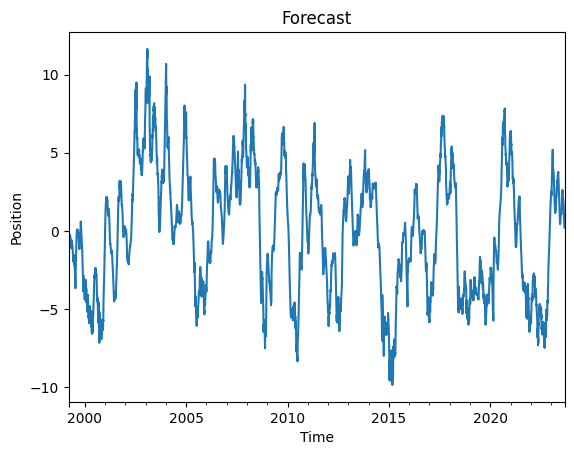

In [13]:
ewmac.plot();
plt.title('Forecast')
plt.ylabel('Position')
plt.xlabel('Time')


Did we make money?


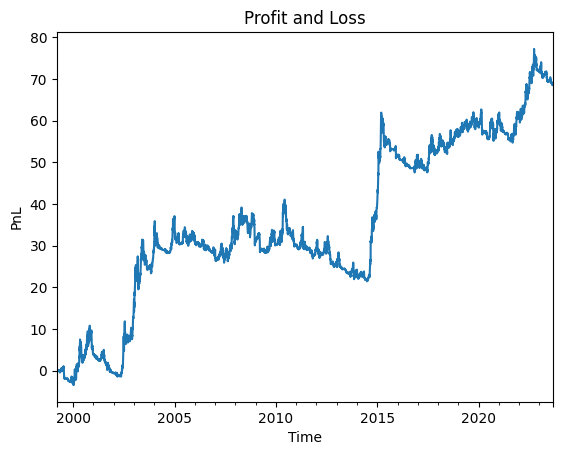

In [14]:
from systems.accounts.account_forecast import pandl_for_instrument_forecast
account = pandl_for_instrument_forecast(forecast=ewmac, price = price)
account.curve().plot();
plt.title('Profit and Loss')
plt.ylabel('PnL')
plt.xlabel('Time');

In [15]:
account.percent.stats()

[[('min', '-3.877'),
  ('max', '4.757'),
  ('median', '0'),
  ('mean', '0.01074'),
  ('std', '0.4395'),
  ('skew', '0.1104'),
  ('ann_mean', '2.75'),
  ('ann_std', '7.033'),
  ('sharpe', '0.3911'),
  ('sortino', '0.4889'),
  ('avg_drawdown', '-7.378'),
  ('time_in_drawdown', '0.9745'),
  ('calmar', '0.1403'),
  ('avg_return_to_drawdown', '0.3728'),
  ('avg_loss', '-0.2768'),
  ('avg_gain', '0.2865'),
  ('gaintolossratio', '1.035'),
  ('profitfactor', '1.084'),
  ('hitrate', '0.5115'),
  ('t_stat', '1.953'),
  ('p_value', '0.05086')],
 ('You can also plot / print:',
  ['rolling_ann_std', 'drawdown', 'curve', 'percent'])]